In [7]:
%%sh
pip install openpyxl --quiet 
pip install lifelines --quiet
pip install scikit-learn --quiet
pip install seaborn --quiet


In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# weird bug in XLSX loading creates annoying warnings, let's turn those off here
import warnings
warnings.simplefilter("ignore")



In [9]:
# patient survival and neoantigen prediction: 
#     A neoantigen fitness model predicts tumour response to checkpoint blockade immunotherapy 
#     https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6137806/
!ls ../data/nature*.xlsx

../data/nature24473_MOESM4_neoantigens.xlsx
../data/nature24473_MOESM5_survival.xlsx


In [10]:
# Luksza 2017 uses three cohorts of checkpoint trial data:
# - Snyder 2014
# - Van Allen 2015
# - Rizvi 2015
cohort_names = [
    "VanAllen",
    "Snyder",
    "Rizvi",
]

In [11]:
# load Luksza 2017 survival data
survival_dataframes = []
for s in cohort_names:
    print("Loading survival data for %s..." % (s,))
    df = pd.read_excel("../data/nature24473_MOESM5_survival.xlsx", sheet_name="Survival %s et al." % s)
    # convert 0/1 to False/True
    df["Status"] = df["Status"].astype(bool)
    df["Cohort"] = s
    survival_dataframes.append(df)
    
df_survival = pd.concat(survival_dataframes)
df_survival


Loading survival data for VanAllen...
Loading survival data for Snyder...
Loading survival data for Rizvi...


,Sample,Months,Status,Cohort
0,Pat02,53.654736,False,VanAllen
1,Pat03,3.287668,True,VanAllen
2,Pat04,32.449280,False,VanAllen
3,Pat06,5.293145,True,VanAllen
4,Pat08,4.602735,True,VanAllen
...,...,...,...,...
29,GR0134,21.900000,False,Rizvi
30,VA1330,23.400000,True,Rizvi
31,NI9507,27.900000,False,Rizvi
32,AU5884,2.400000,True,Rizvi


In [12]:
# load Luksza 2017 neoantigen data
# ...but we're not using it yet...

neoag_dataframes = []
for s in cohort_names:
    print("Loading neoantigens data for %s..." % (s,))
    df = pd.read_excel("../data/nature24473_MOESM4_neoantigens.xlsx", sheet_name=s + " et al.")
    df["Cohort"] = s
    neoag_dataframes.append(df)
    
df_neoag = pd.concat(neoag_dataframes);
df_neoag


Loading neoantigens data for VanAllen...
Loading neoantigens data for Snyder...
Loading neoantigens data for Rizvi...


,ID,MUTATION_ID,Sample,WT.Peptide,MT.Peptide,MT.Allele,WT.Score,MT.Score,HLA,Cohort
0,1,1_1563747_C_T_Pat02,Pat02,NHREVAQIL,NYREVAQIL,C0702,701,70,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
1,2,1_17087582_G_A_Pat02,Pat02,SPSNDFQVL,SPLNDFQVL,B0801,739,202,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
2,3,1_17087582_G_A_Pat02,Pat02,SPSNDFQVL,SPLNDFQVL,B0702,32,37,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
3,4,1_21806573_A_G_Pat02,Pat02,LLDEKEPEV,LLDEKGPEV,A0201,8,9,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
4,5,1_46073697_C_T_Pat02,Pat02,KPGQEAPVL,KPGQEASVL,B0702,90,31,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
...,...,...,...,...,...,...,...,...,...,...
4943,4944,8_113697930_C_A_ZA6965,ZA6965,CLSNFTAPM,CLSNFTAPI,A3201,1850,71,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi
4944,4945,X_68749680_T_A_ZA6965,ZA6965,RLCVLVLML,RLSVLVLML,A0201,419,172,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi
4945,4946,X_68749680_T_A_ZA6965,ZA6965,RLCVLVLML,RLSVLVLML,A3201,516,314,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi
4946,4947,X_68749680_T_A_ZA6965,ZA6965,SRIRLCVLV,SRIRLSVLV,C0602,751,146,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi


In [13]:
# let's threshold the survival times into binary labels for classification

df_survival["survived_1yr"] = df_survival.Months >= 12
df_survival["survived_2yr"] = df_survival.Months >= 24
df_survival["survived_3yr"] = df_survival.Months >= 36

# also, let's note when we know if a patient got to the thresholded time 
# by either surviving that long or dying previously
df_survival["known_at_1yr"] = df_survival.survived_1yr | df_survival.Status
df_survival["known_at_2yr"] = df_survival.survived_2yr | df_survival.Status
df_survival["known_at_3yr"] = df_survival.survived_3yr | df_survival.Status

df_survival

,Sample,Months,Status,Cohort,survived_1yr,survived_2yr,survived_3yr,known_at_1yr,known_at_2yr,known_at_3yr
0,Pat02,53.654736,False,VanAllen,True,True,True,True,True,True
1,Pat03,3.287668,True,VanAllen,False,False,False,True,True,True
2,Pat04,32.449280,False,VanAllen,True,True,False,True,True,False
3,Pat06,5.293145,True,VanAllen,False,False,False,True,True,True
4,Pat08,4.602735,True,VanAllen,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...
29,GR0134,21.900000,False,Rizvi,True,False,False,True,False,False
30,VA1330,23.400000,True,Rizvi,True,False,False,True,True,True
31,NI9507,27.900000,False,Rizvi,True,True,False,True,True,False
32,AU5884,2.400000,True,Rizvi,False,False,False,True,True,True


In [37]:
print("Fraction of patients with 1yr survival (or earlier censoring): %0.2f" % (df_survival.survived_1yr.mean(),))
print("Fraction of patients with 2yr survival (or earlier censoring): %0.2f" % (df_survival.survived_2yr.mean(),))
print("Fraction of patients with 3yr survival (or earlier censoring): %0.2f" % (df_survival.survived_3yr.mean(),))

print("---")
print("Fraction of patients with known 1yr outcome: %0.2f" % (df_survival.known_at_1yr.mean(),))
print("Fraction of patients with known 2yr outcome: %0.2f" % (df_survival.known_at_2yr.mean(),))
print("Fraction of patients with known 3yr outcome: %0.2f" % (df_survival.known_at_3yr.mean(),))


Fraction of patients with 1yr survival (or earlier censoring): 0.57
Fraction of patients with 2yr survival (or earlier censoring): 0.38
Fraction of patients with 3yr survival (or earlier censoring): 0.15
---
Fraction of patients with known 1yr outcome: 1.00
Fraction of patients with known 2yr outcome: 0.94
Fraction of patients with known 3yr outcome: 0.79


In [39]:
# to create a source of random sequence data for each patient to use a source for featurization
# let's take the top-3 neoantigens ranked by MHC binding affinity
top_3_neoags_per_sample = df_neoag.sort_values("MT.Score").groupby("Sample").head(3).groupby("Sample")["MT.Peptide"].apply("|".join);
top_3_neoags_per_sample.name = "Top_3_Neoantigen_Sequences"
top_3_neoags_per_sample

Sample
AL4602    KMFLAVLSF|KILQLTLNF|KVVYFMATF
AU5884    RYVAIYNPI|LLLEKVEFL|NYIFRLFQF
BL3403    ITDFGHSEI|ILDECQNLM|MPTMASVKL
CA9903    ILYGYWWPL|YLNELVVFV|FLHEIFHQV
CR0095    YLMDWMKEM|FIFGDTILV|FMIGSMELI
                      ...              
TU0428    IPFAVILPF|YPFLGAVCF|MAVCHPLQY
WA7899    KFMAVFYTI|QAEYATIVF|TPTDNANSF
Y2087     KQYQKEAYR|CPLLNITAM|KMGKCCHHR
ZA6505    NEYDLWTAY|FAFLLVSYV|MAYDRYVAI
ZA6965    FLNFLILVV|STSQGTFTF|ALPPCLIPL
Name: Top_3_Neoantigen_Sequences, Length: 205, dtype: object

In [32]:
# let's sanity check the sequences for the first sample AL4602

AL4602_neoags = df_neoag[df_neoag.Sample == "AL4602"].sort_values("MT.Score");
AL4602_neoags


,ID,MUTATION_ID,Sample,WT.Peptide,MT.Peptide,MT.Allele,WT.Score,MT.Score,HLA,Cohort
25,26,12_21007975_C_T_AL4602,AL4602,KMFLAALSF,KMFLAVLSF,A3201,4,3,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
57,58,2_163361083_G_A_AL4602,AL4602,KIPQLTLNF,KILQLTLNF,A3201,17,6,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
10,11,11_20648267_C_T_AL4602,AL4602,KVVYFTATF,KVVYFMATF,A3201,5,11,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
15,16,11_56114447_A_T_AL4602,AL4602,RTLTNRFKI,RTFTNRFKI,A3201,36,14,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
45,46,16_57188221_G_C_AL4602,AL4602,SSIFRTNTF,SSIFRTNSF,A3201,13,17,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
...,...,...,...,...,...,...,...,...,...,...
19,20,11_63137761_C_A_AL4602,AL4602,ISIPLDSNM,ISIQLDSNM,C1502,310,452,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
9,10,10_73579374_C_T_AL4602,AL4602,LTVHVTQPK,LTVHMTQPK,A0301,442,460,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
74,75,5_170239030_G_A_AL4602,AL4602,SFKRKISFA,SFKQKISFA,B0801,212,470,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
76,77,6_32714125_A_G_AL4602,AL4602,TVFIIQGLR,TVFIIRGLR,A0301,471,494,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi


In [36]:
print(top_3_neoags_per_sample["AL4602"])
print("|".join(AL4602_neoags["MT.Peptide"][:3]))
top_3_neoags_per_sample["AL4602"] == "|".join(AL4602_neoags["MT.Peptide"][:3])

KMFLAVLSF|KILQLTLNF|KVVYFMATF
KMFLAVLSF|KILQLTLNF|KVVYFMATF


True

In [437]:
# let's sanity check the sequences for the last sample ZA6965

ZA6965_neoags = df_neoag[df_neoag.Sample == "ZA6965"].sort_values("MT.Score");
print(top_3_neoags_per_sample["ZA6965"])
print("|".join(ZA6965_neoags["MT.Peptide"][:3]))
top_3_neoags_per_sample["ZA6965"] == "|".join(ZA6965_neoags["MT.Peptide"][:3])

FLNFLILVV|STSQGTFTF|ALPPCLIPL
FLNFLILVV|STSQGTFTF|ALPPCLIPL


True

In [48]:
# now let's join the neoag and survival tables 
# (dropping some patients since the samples in these tables don't perfectly match)

df_join_left = df_survival.join(top_3_neoags_per_sample, on="Sample", how="left");
df_join_inner = df_survival.join(top_3_neoags_per_sample, on="Sample", how="inner");
print(len(df_join_left), "vs.", len(df_join_inner))
df_join_inner

201 vs. 198


,Sample,Months,Status,Cohort,survived_1yr,survived_2yr,survived_3yr,known_at_1yr,known_at_2yr,known_at_3yr,Top_3_Neoantigen_Sequences
0,Pat02,53.654736,False,VanAllen,True,True,True,True,True,True,WMLRKHHSF|MAWGSLFHV|MLRKHHSFA
1,Pat03,3.287668,True,VanAllen,False,False,False,True,True,True,WPADAPFWM|HPRAVSISF|IAFSYWSVY
2,Pat04,32.449280,False,VanAllen,True,True,False,True,True,False,YAYIIKTIL|LAAPMSRSL|TLFPFLFVV
3,Pat06,5.293145,True,VanAllen,False,False,False,True,True,True,AAIPPPPPL|FAASQKEEL|YSSDSSVTL
4,Pat08,4.602735,True,VanAllen,False,False,False,True,True,True,LAVMAYDCY|MVHNLVPPY|FPHIFGFTL
...,...,...,...,...,...,...,...,...,...,...,...
27,LO3793,6.800000,False,Rizvi,False,False,False,False,False,False,WLLALSPNL|GLLAGTLAV|MLSELSIII
28,LO5004,22.700000,True,Rizvi,True,False,False,True,True,True,FAFLSVEDL|FALLSNTGF|FVFLAALFL
29,GR0134,21.900000,False,Rizvi,True,False,False,True,False,False,TRSTHNLKV|QHHHHHHHL|RLIYAVHLA
31,NI9507,27.900000,False,Rizvi,True,True,False,True,True,False,GLLEALLPV|YMLTLHTKL|LMIRWLRGV


p-value = 7.3310511199250725e-59


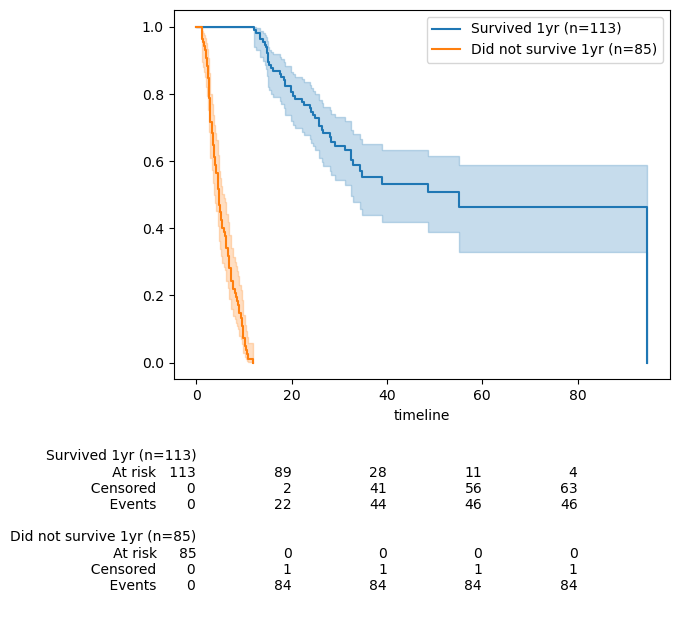

In [49]:
# sanity check that 1yr binary survival threshold is still a good basis for splitting the survival curves
# on our 198 patient subset

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts


ax = plt.subplot(111)

# plot the 1yr survivors
df_yes = df_join_inner[df_join_inner.survived_1yr]
kmf_yes = KaplanMeierFitter()
kmf_yes.fit(df_yes.Months, 
        event_observed=df_yes.Status, 
        label="Survived 1yr (n=%d)" % len(df_yes))  
kmf_yes.plot_survival_function(ax=ax)

# plot the 1yr non-survivors
df_no = df_join_inner[~df_join_inner.survived_1yr]
kmf_no = KaplanMeierFitter()
kmf_no.fit(df_no.Months, 
        event_observed=df_no.Status, 
        label="Did not survive 1yr (n=%d)" % len(df_no))
kmf_no.plot_survival_function(ax=ax)
add_at_risk_counts(kmf_yes, kmf_no)


from lifelines.statistics import logrank_test
hypothesis_test_result = logrank_test(df_yes.Months, df_no.Months, event_observed_A=df_yes.Status, event_observed_B=df_no.Status)
print("p-value = %s" % (hypothesis_test_result.p_value,))

In [430]:
# LET'S GENERATE SOME FEATURES!


# given a column of a dataframe, generate all counts of combinations up to length k
from tqdm import tqdm

def generate_count_features(column, k=1, ignore_constant_tokens=True):
    assert k >= 1
    unique_values = sorted(set("".join(column)))
    print("Unique tokens in %s: %s" % (column.name, unique_values))
    counts = {}

    print("Generating singleton count features...")
    for c in tqdm(unique_values):
        counts[c] = np.array([p.count(c) for p in column])
    
    if ignore_constant_tokens:
        # drop constant token counts
        ignore_tokens = {c for (c, v) in counts.items() if (v[0] == v[1:]).all()}
        counts = {c: v for (c, v) in counts.items() if c not in ignore_tokens}
        unique_values = [c for c in unique_values if c not in ignore_tokens]
    
    for i in range(2, k + 1):
        higher_order_counts = {}
        print("Generating counts of %d characters" % (i,))
   
        for old_feature_name, old_feature_values in tqdm(list(counts.items())):
            for c in unique_values:
                if c not in old_feature_name:
                    new_name = "".join(sorted(old_feature_name + c))
                    if new_name not in higher_order_counts:
                        higher_order_counts[new_name] = old_feature_values + counts[c]
        counts.update(higher_order_counts)
    print("Total number of generated features = %d" % (len(counts),))
    return pd.DataFrame(counts, index=column.index);

In [419]:
# LET'S GENERATE SOME FEATURES!


# given a column of a dataframe, generate all counts of combinations up to length k
from tqdm import tqdm

def remove_duplicate_features(counts):
    dedup = {}
    print("Looking for duplicate columns")
    for name, values in tqdm(counts.items()):
        found_duplicate = False
        for other_name, other_values in dedup.items():
            if (values == other_values).all():
                found_duplicate = True
                break
        if not found_duplicate:
            dedup[name] = values
    print("Removed %d duplicate features" % (len(counts) - len(dedup)))
    return dedup

def generate_kmer_features(column, k=1, ignore=set(), include_lower_order=True, remove_duplicates=False):
    assert k >= 1
    unique_values = sorted(set("".join(column)).difference(ignore))
    print("Unique tokens in %s: %s" % (column.name, unique_values))
    counts = {}

    print("Generating singleton count features...")
    for c in tqdm(unique_values):
        counts[c] = np.array([p.count(c) for p in column])
    
    for i in range(2, k + 1):
        higher_order_counts = {}
        print("Generating counts of %d characters" % (i,))
   
        for old_name, old_feature_values in tqdm(list(counts.items())):
            for c in unique_values:
                combo = old_name + c
                vec = np.array([p.count(combo) for p in column])
                if vec.sum() == 0:
                    # skip vectors of all 0s
                    continue
                higher_order_counts[combo] = vec
        
        counts.update(higher_order_counts)
    if not include_lower_order:
        counts = {name: values for (name, values) in counts if len(name) == k}
    if remove_duplicates:
        counts = remove_duplicate_features(counts)
    print("Total number of generated features = %d" % (len(counts),))
    return pd.DataFrame(counts, index=column.index);

In [403]:
generate_kmer_features(df_join_inner.Top_3_Neoantigen_Sequences, k=5, ignore="|")

Unique tokens in Top_3_Neoantigen_Sequences: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Generating singleton count features...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 11694.70it/s]


Generating counts of 2 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1087.33it/s]


Generating counts of 3 characters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 413/413 [00:00<00:00, 1603.97it/s]


Generating counts of 4 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3031/3031 [00:01<00:00, 1873.20it/s]


Generating counts of 5 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6372/6372 [00:03<00:00, 1880.44it/s]


Looking for duplicate columns


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9266/9266 [00:04<00:00, 1923.57it/s]

Removed 7750 duplicate features
Total number of generated features = 1516


,A,C,D,E,F,G,H,I,K,L,...,SMAL,SPSL,SSSF,SSTI,TFFI,TFSF,TLSA,TPMY,TSAA,VLLF
0,2,0,0,0,3,1,5,0,2,3,...,0,0,0,0,0,0,0,0,0,0
1,4,0,1,0,3,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,3,0,0,3,1,5,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,2,1,0,0,1,1,3,...,0,0,0,0,0,0,0,0,0,0
4,2,1,1,0,3,1,2,1,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3,0,0,1,0,2,0,3,0,9,...,0,0,0,0,0,0,0,0,0,0
28,4,0,1,1,7,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
29,2,0,0,0,0,0,9,1,1,4,...,0,0,0,0,0,0,0,0,0,0
31,1,0,0,1,0,2,1,1,1,9,...,0,0,0,0,0,0,0,0,0,0


In [404]:
df_join_inner.Top_3_Neoantigen_Sequences

0     WMLRKHHSF|MAWGSLFHV|MLRKHHSFA
1     WPADAPFWM|HPRAVSISF|IAFSYWSVY
2     YAYIIKTIL|LAAPMSRSL|TLFPFLFVV
3     AAIPPPPPL|FAASQKEEL|YSSDSSVTL
4     LAVMAYDCY|MVHNLVPPY|FPHIFGFTL
                  ...              
27    WLLALSPNL|GLLAGTLAV|MLSELSIII
28    FAFLSVEDL|FALLSNTGF|FVFLAALFL
29    TRSTHNLKV|QHHHHHHHL|RLIYAVHLA
31    GLLEALLPV|YMLTLHTKL|LMIRWLRGV
32    RYVAIYNPI|LLLEKVEFL|NYIFRLFQF
Name: Top_3_Neoantigen_Sequences, Length: 198, dtype: object

In [405]:
# generate raw features to use in a classifier from amino acid content of the top 3 neoantigens
df_new_features_1 = generate_kmer_features(df_join_inner.Top_3_Neoantigen_Sequences, k=1, ignore="|")
df_new_features_1

Unique tokens in Top_3_Neoantigen_Sequences: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Generating singleton count features...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32005.37it/s]


Looking for duplicate columns


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 73778.43it/s]

Removed 0 duplicate features
Total number of generated features = 20


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,2,0,0,0,3,1,5,0,2,3,3,0,0,0,2,3,0,1,2,0
1,4,0,1,0,3,0,1,2,0,0,1,0,3,0,1,4,0,2,3,2
2,3,0,0,0,3,0,0,3,1,5,1,0,2,0,1,2,2,2,0,2
3,4,0,1,2,1,0,0,1,1,3,0,0,5,1,0,5,1,1,0,1
4,2,1,1,0,3,1,2,1,0,3,2,1,3,0,0,0,1,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3,0,0,1,0,2,0,3,0,9,1,1,1,0,0,3,1,1,1,0
28,4,0,1,1,7,1,0,0,0,7,0,1,0,0,0,2,1,2,0,0
29,2,0,0,0,0,0,9,1,1,4,0,1,0,1,2,1,2,2,0,1
31,1,0,0,1,0,2,1,1,1,9,2,0,1,0,2,0,2,2,1,1


In [406]:
feature_names_1 = sorted(df_new_features_1.columns);
feature_names_1

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

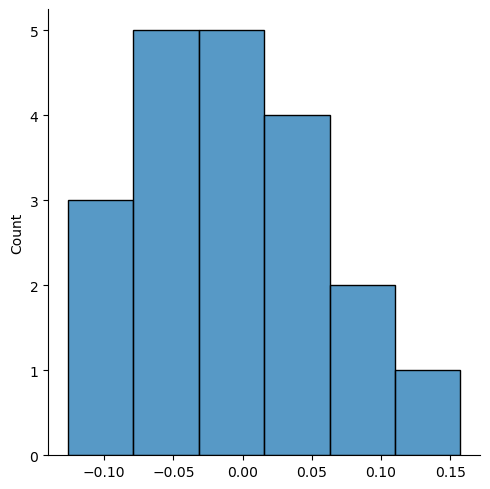

In [438]:
# get the correlation of every feature with the target label
correlations_1 = df_new_features_1.corrwith(df_join_inner.survived_1yr);
# plot the distribution of random correlations
sns.displot(correlations_1)

In [439]:
# which features are most strongly correlated?
correlations_1.sort_values()

V   -0.126348
A   -0.122434
P   -0.104721
K   -0.048181
Q   -0.045551
C   -0.041628
H   -0.034846
G   -0.031800
S   -0.015342
W   -0.000885
N    0.008314
R    0.012954
F    0.014241
I    0.031010
T    0.038692
L    0.043970
D    0.056473
E    0.073289
M    0.079162
Y    0.157334
dtype: float64

In [440]:
# generate raw features to use in a classifier from the PATIENT/SAMPLE IDs (!!)
df_new_features_2 = generate_kmer_features(df_join_inner.Top_3_Neoantigen_Sequences, k=2, ignore="|")
df_new_features_2

Unique tokens in Top_3_Neoantigen_Sequences: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Generating singleton count features...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 6449.80it/s]


Generating counts of 2 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1305.66it/s]

Total number of generated features = 413


,A,C,D,E,F,G,H,I,K,L,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
0,2,0,0,0,3,1,5,0,2,3,...,0,0,0,0,0,0,0,0,0,0
1,4,0,1,0,3,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,3,0,0,3,1,5,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,2,1,0,0,1,1,3,...,0,0,0,0,0,1,0,0,0,0
4,2,1,1,0,3,1,2,1,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3,0,0,1,0,2,0,3,0,9,...,0,0,0,0,0,0,0,0,0,0
28,4,0,1,1,7,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
29,2,0,0,0,0,0,9,1,1,4,...,0,0,0,0,0,0,0,0,0,0
31,1,0,0,1,0,2,1,1,1,9,...,1,0,0,0,0,0,0,0,0,0


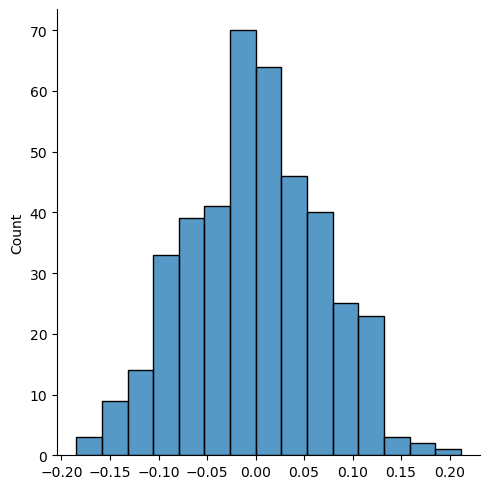

In [441]:
# get the correlation of every feature with the target label
correlations_2 = df_new_features_2.corrwith(df_join_inner.survived_1yr);
# plot the distribution of random correlations
sns.displot(correlations_2)

In [458]:
# to look at the impact of generating more features, let's try every order of counts from 1 to 10
order_to_count_features = {}

ks = np.arange(1, 7)

max_k = ks.max()
df_features_max_k = generate_kmer_features(
    df_join_inner.Top_3_Neoantigen_Sequences, k=max_k, ignore="|", include_lower_order=True, remove_duplicates=True)
columns = df_features_max_k.columns
for k in ks:
    print("k=%d" % k)
    subset = [c for c in columns if len(c) <= k]
    order_to_count_features[k] = df_features_max_k[subset]

Unique tokens in Top_3_Neoantigen_Sequences: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Generating singleton count features...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 15082.00it/s]


Generating counts of 2 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1207.45it/s]


Generating counts of 3 characters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 413/413 [00:00<00:00, 1632.75it/s]


Generating counts of 4 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3031/3031 [00:01<00:00, 1870.68it/s]


Generating counts of 5 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6372/6372 [00:03<00:00, 1870.93it/s]


Generating counts of 6 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9266/9266 [00:04<00:00, 1867.87it/s]


Looking for duplicate columns


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11592/11592 [00:06<00:00, 1906.39it/s]

Removed 10076 duplicate features
Total number of generated features = 1516
k=1
k=2
k=3
k=4
k=5
k=6


In [459]:
 order_to_count_features[4]

,A,C,D,E,F,G,H,I,K,L,...,SMAL,SPSL,SSSF,SSTI,TFFI,TFSF,TLSA,TPMY,TSAA,VLLF
0,2,0,0,0,3,1,5,0,2,3,...,0,0,0,0,0,0,0,0,0,0
1,4,0,1,0,3,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,3,0,0,3,1,5,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,2,1,0,0,1,1,3,...,0,0,0,0,0,0,0,0,0,0
4,2,1,1,0,3,1,2,1,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3,0,0,1,0,2,0,3,0,9,...,0,0,0,0,0,0,0,0,0,0
28,4,0,1,1,7,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
29,2,0,0,0,0,0,9,1,1,4,...,0,0,0,0,0,0,0,0,0,0
31,1,0,0,1,0,2,1,1,1,9,...,0,0,0,0,0,0,0,0,0,0


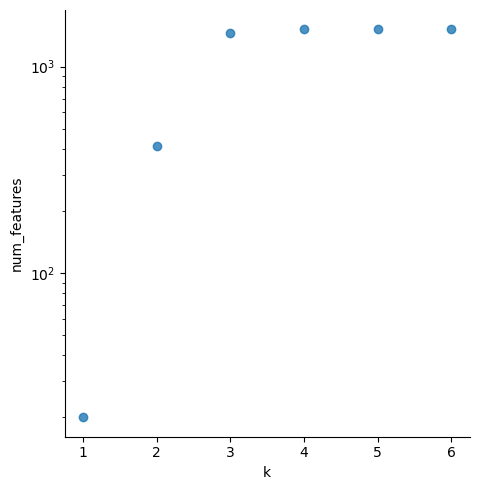

In [460]:

num_features_per_k = [
    len(order_to_count_features[k].columns) for k in ks
]
sns.lmplot(data=pd.DataFrame({"k": ks, "num_features": num_features_per_k}), x="k", y="num_features", fit_reg=False)
plt.yscale('log')

In [461]:
correlations_per_k = {}
for k in ks:
    print("Computing survival label correlations for k=%d" % k)
    correlations_per_k[k] = order_to_count_features[k].corrwith(df_join_inner.survived_1yr)

    

Computing survival label correlations for k=1
Computing survival label correlations for k=2
Computing survival label correlations for k=3
Computing survival label correlations for k=4
Computing survival label correlations for k=5
Computing survival label correlations for k=6


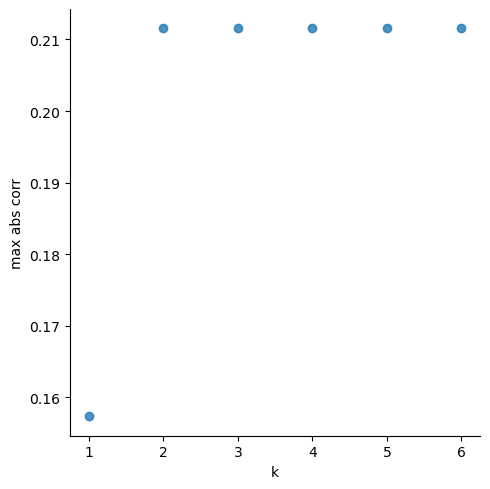

In [462]:
top_corr_per_k = [
    correlations_per_k[k].abs().max()
    for k in ks
]
sns.lmplot(data=pd.DataFrame({"k": ks, "max abs corr": top_corr_per_k}), x="k", y="max abs corr", fit_reg=False)



In [665]:
def random_split(X, y):
    np.random.seed(42)
    all_indices = np.arange(len(X))
    np.random.shuffle(all_indices)
    train_indices = all_indices[:len(X)//2]
    test_indices = all_indices[len(X)//2:]

    X_train = X[train_indices, :]
    X_test = X[test_indices, :]
    y_train = y[train_indices]
    y_test = y[test_indices]    
    print("%dx%d training samples (%0.2f%% survival), %dx%d test samples (%0.2f%% survival)" % (
        len(X_train),
        X_train.shape[1],
        y_train.mean() * 100,
        len(X_test),
        X_test.shape[1],
        y_test.mean() * 100
    ))
    return X_train, X_test, y_train, y_test, train_indices, test_indices

In [666]:
np.corrcoef([1,2,3],[1,2,3])

array([[1., 1.],
       [1., 1.]])

In [667]:
count_order = 4

X = order_to_count_features[count_order].values
y = df_join_inner.survived_1yr.values

X_train, X_test, y_train, y_test, train_indices, test_indices = random_split(X, y)

df_train = df_join_inner.iloc[train_indices]
df_test = df_join_inner.iloc[test_indices]


99x1516 training samples (57.58% survival), 99x1516 test samples (56.57% survival)


In [685]:
# use feature importances to choose features

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier


max_features_to_select = 200
print("Selecting top #%d features from total %d" % (max_features_to_select, X.shape[1]))

feature_indices = np.argsort(RandomForestClassifier(20).fit(X, y).feature_importances_)[::-1][:max_features_to_select]


Selecting top #200 features from total 1516


In [ ]:


n_features_vec = []
accuracies = []
p_values = []

for n_features in np.arange(1, max_features_to_select + 1):
    print("== n_features = %d" % n_features)
    
    curr_feature_indices = feature_indices[:n_features]
    print(correlations_per_k[count_order].iloc[curr_feature_indices])
    X_train_selected = X_train[:, curr_feature_indices]
    X_test_selected = X_test[:, curr_feature_indices]

    
    # let's fit a model on just the training set
    model = LogisticRegression()
    model.fit(X_train_selected, y_train)
    
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)
    assert (df_test.survived_1yr == y_test).all()
    df_yes = df_test[y_test_pred]
    df_no = df_test[~y_test_pred]
    
    if len(df_no) == 0 or len(df_yes) == 0:
        continue
    n_features_vec.append(n_features)
    # are these predictions any good?
    acc = np.mean(y_test_pred == y_test)
    accuracies.append(acc)
    print("Accuracy = %0.2f%%" % (100 * np.mean(y_test_pred == y_test)))
    # now let's apply this predictor to split survival curves
    
    from lifelines.statistics import logrank_test
    hypothesis_test_result = logrank_test(
        df_yes.Months,
        df_no.Months,
        event_observed_A=df_yes.Status,
        event_observed_B=df_no.Status)
    
    print("p-value = %s" % (hypothesis_test_result.p_value,))
    p_values.append(hypothesis_test_result.p_value)

== n_features = 1
L    0.04397
dtype: float64
== n_features = 2
L     0.043970
YF    0.179567
dtype: float64
Accuracy = 54.55%
p-value = 0.3910178110404926
== n_features = 3
L     0.043970
YF    0.179567
SN   -0.140858
dtype: float64
Accuracy = 58.59%
p-value = 0.0645269204572624
== n_features = 4
L     0.043970
YF    0.179567
SN   -0.140858
LY    0.085956
dtype: float64
Accuracy = 58.59%
p-value = 0.0645269204572624
== n_features = 5
L     0.043970
YF    0.179567
SN   -0.140858
LY    0.085956
F     0.014241
dtype: float64
Accuracy = 57.58%
p-value = 0.3925242343920866
== n_features = 6
L     0.043970
YF    0.179567
SN   -0.140858
LY    0.085956
F     0.014241
GT   -0.126135
dtype: float64
Accuracy = 56.57%
p-value = 0.8251926723148895
== n_features = 7
L     0.043970
YF    0.179567
SN   -0.140858
LY    0.085956
F     0.014241
GT   -0.126135
EQ   -0.165561
dtype: float64
Accuracy = 56.57%
p-value = 0.7115055481828119
== n_features = 8
L     0.043970
YF    0.179567
SN   -0.140858
LY    

Accuracy = 63.64%
p-value = 0.11941294443595687
== n_features = 45
L      0.043970
YF     0.179567
SN    -0.140858
LY     0.085956
F      0.014241
GT    -0.126135
EQ    -0.165561
A     -0.122434
FL    -0.012839
K     -0.048181
DF     0.147516
S     -0.015342
HP    -0.055665
EY     0.111551
P     -0.104721
V     -0.126348
IH    -0.184771
SF    -0.045510
MT    -0.153635
AI    -0.093227
IK    -0.118418
AA    -0.147154
NR    -0.072263
LWL   -0.165561
M      0.079162
QF    -0.140858
HH     0.124537
I      0.031010
FIL   -0.124245
YS    -0.009138
FY     0.211544
HR    -0.104650
H     -0.034846
GV    -0.040494
TV     0.005133
ES     0.110784
T      0.038692
YPN   -0.116471
Y      0.157334
LK     0.061709
AH    -0.132951
SSV   -0.165561
C     -0.041628
MS     0.110784
TDS   -0.143012
dtype: float64
Accuracy = 63.64%
p-value = 0.11941294443595687
== n_features = 46
L       0.043970
YF      0.179567
SN     -0.140858
LY      0.085956
F       0.014241
GT     -0.126135
EQ     -0.165561
A      -0.12

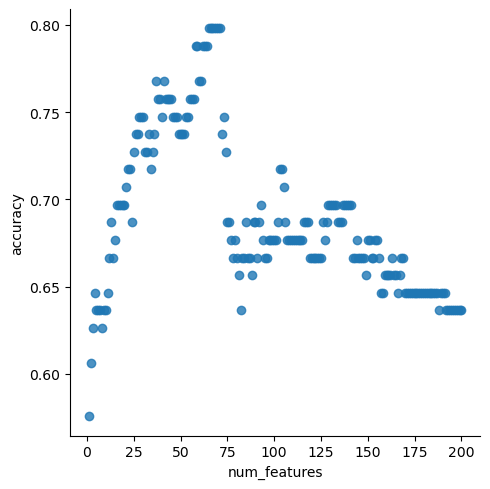

In [683]:


sns.lmplot(data=pd.DataFrame({ "num_features": n_features_vec, "accuracy": accuracies}), x="num_features", y="accuracy", fit_reg=False)


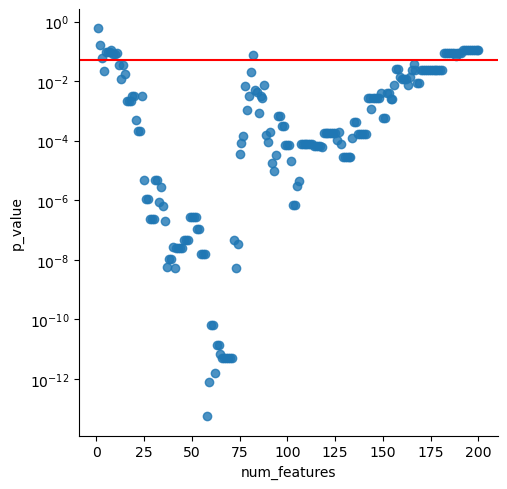

In [684]:
sns.lmplot(data=pd.DataFrame({ "num_features": n_features_vec, "p_value": p_values}), x="num_features", y="p_value", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.yscale('log')

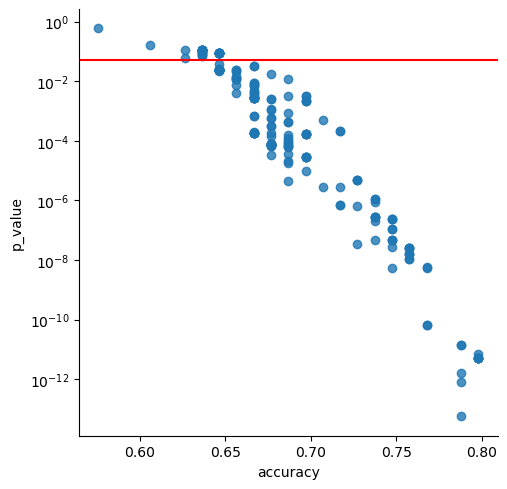

In [682]:
sns.lmplot(data=pd.DataFrame({ "accuracy": accuracies, "p_value": p_values}), x="accuracy", y="p_value", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.yscale('log')